In [1]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
cm = coinmetrics.Community()
moneda = 'dcr'
available_data_types = cm.get_available_data_types_for_asset(moneda)

#metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapRealUSD,CapMrktCurUSD,DiffMean,FeeMeanNtv,\
#FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,\
#NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
#TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,\
#VtyDayRet30d,VtyDayRet60d"

metrica = "AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,\
FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d"

begin_timestamp = "2009-01-01"
end_timestamp = '2020-11-28'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [3]:
start_time = time.time()
db = coinmetrics.cm_to_pandas(asset_data)
db.index = np.arange(len(db))
db = db.interpolate(method='polynomial', order=2)
end_time = time.time()
print("Segundos", end_time - start_time)

Segundos 0.054682254791259766


In [4]:
for name in db.columns:
    db[name] = db[name].fillna(0)    

In [5]:
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1

db = db[~((db < (Q1 - 1.5 * IQR)) |(db > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
df = pd.DataFrame(db.values)
df.columns = db.columns

In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet().fit(data)
    m = robust_cov.mahalanobis(data)
    # one popular way to specify the threshold
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = False))

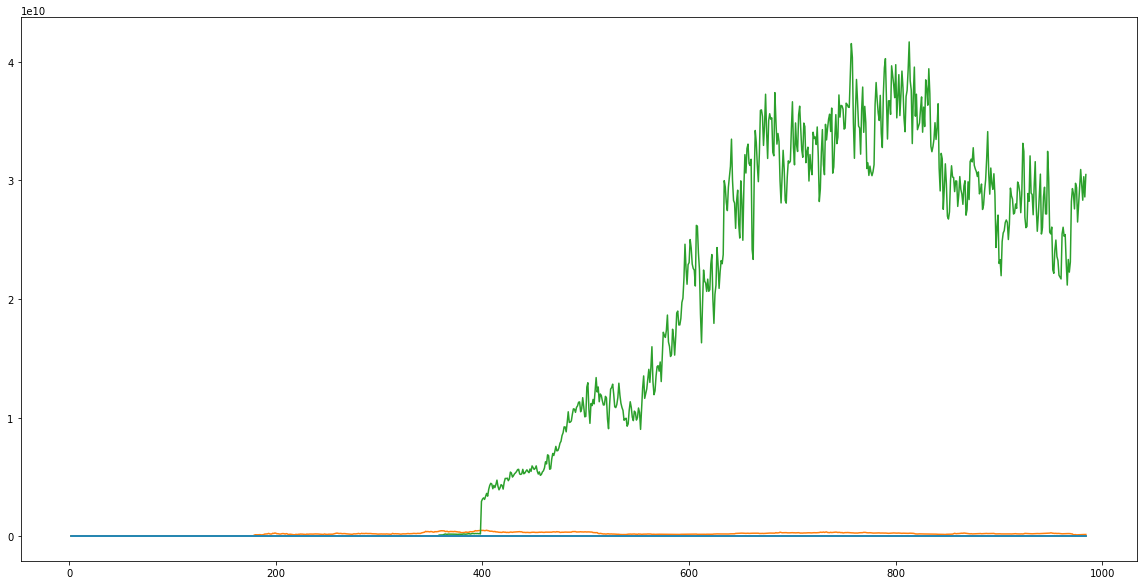

In [8]:
plt.plot(df_wo)
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

#Con todas las metricas

X = df_wo[['AdrActCnt','BlkCnt','BlkSizeByte','BlkSizeMeanByte','CapMrktCurUSD','CapRealUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','NVTAdj','NVTAdj90','PriceBTC','ROI1yr','ROI30d','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','TxTfrValNtv','TxTfrValUSD','VtyDayRet180d','VtyDayRet30d','VtyDayRet60d']]
y = df_wo['PriceUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size   = 0.8, random_state = 1234, shuffle = True)

In [45]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:14:01   Log-Likelihood:                -121.80
No. Observations:                 413   AIC:                             309.6
Df Residuals:                     380   BIC:                             442.4
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.9923      1

## Eliminamos las variables con p-value < 0.05 ya que no aportan de forma significativa al modelo

## Total **variables restantes 23**

In [46]:
#df_regresion_wo = df_wo.drop(['BlkSizeByte', 'BlkCnt','BlkSizeMeanByte','DiffMean','FeeMeanNtv','FeeTotUSD','NVTAdj','NVTAdj90','PriceBTC','TxCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','VtyDayRet60d'], axis=1)

In [9]:
x = df_wo.values
#x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_wo.columns
#df.columns = df_regresion_wo.columns

In [10]:
model = pca()
# Fit transform
out = model.fit_transform(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [11] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [11]:
print(out['topfeat'])

      PC          feature   loading  type
0    PC1         DiffMean -0.462922  best
1    PC2         PriceUSD  0.523449  best
2    PC3         TxTfrCnt  0.575940  best
3    PC4     VtyDayRet30d  0.853645  best
4    PC5        FeeTotNtv  0.687953  best
5    PC6      TxTfrValUSD  0.547093  best
6    PC7        FeeTotNtv  0.486766  best
7    PC8  TxTfrValMeanUSD -0.605156  best
8    PC9         TxTfrCnt  0.563780  best
9   PC10    CapMrktCurUSD -0.610971  best
10  PC11           SplyFF  0.714998  best
11   PC9        AdrActCnt -0.513344  weak
12  PC11          SplyCur -0.699028  weak


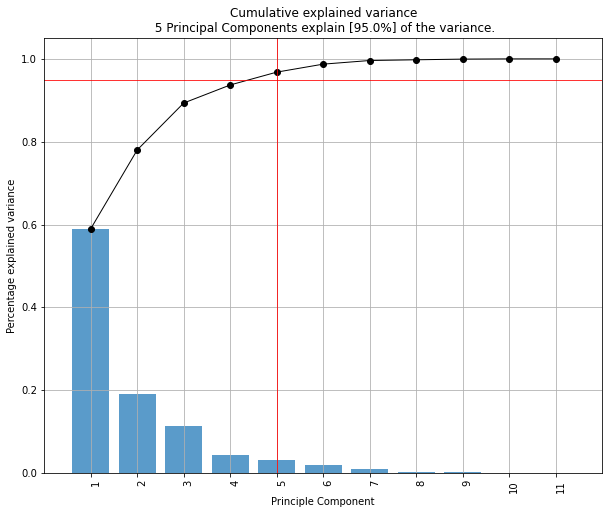

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc03593ffd0>)

<Figure size 1440x720 with 0 Axes>

In [12]:
model.plot()

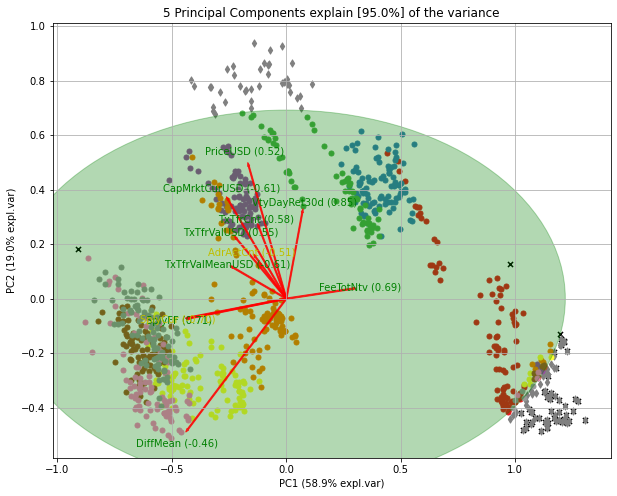

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc035c8b520>)

In [13]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

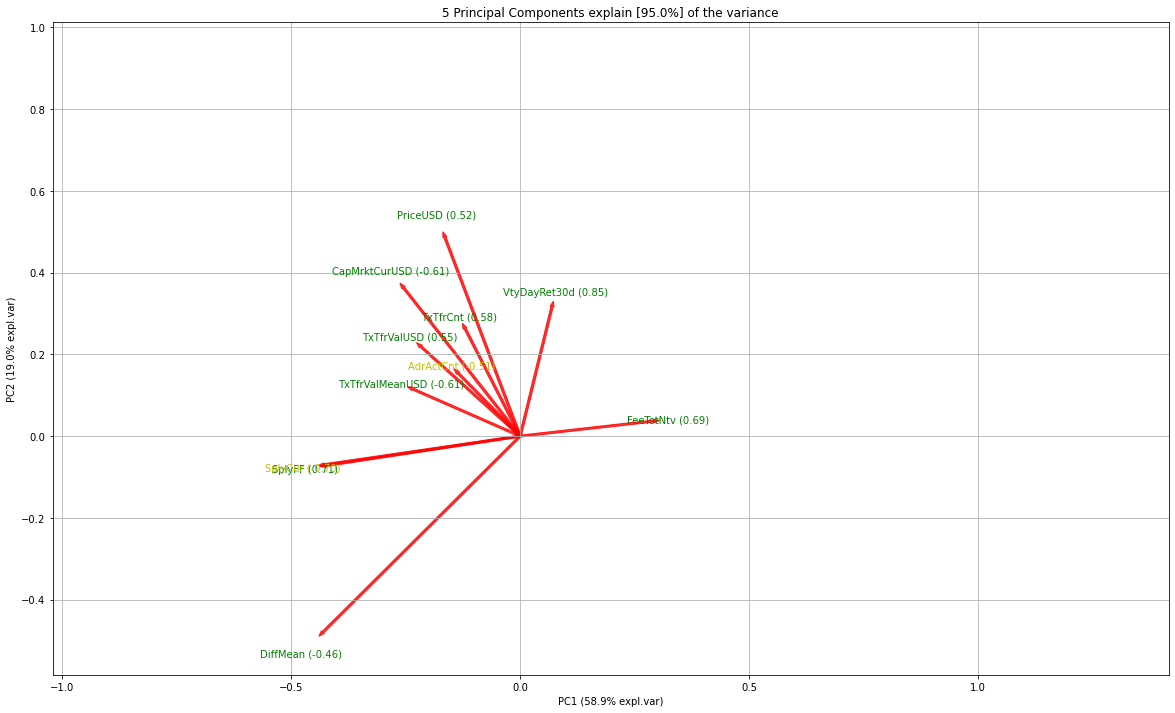

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc0341ae250>)

In [14]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

['AdrActCnt' 'CapMrktCurUSD' 'DiffMean' 'PriceUSD' 'FeeTotNtv' 'SplyCur'
 'SplyFF' 'TxTfrCnt' 'TxTfrValMeanUSD' 'TxTfrValUSD' 'VtyDayRet30d']


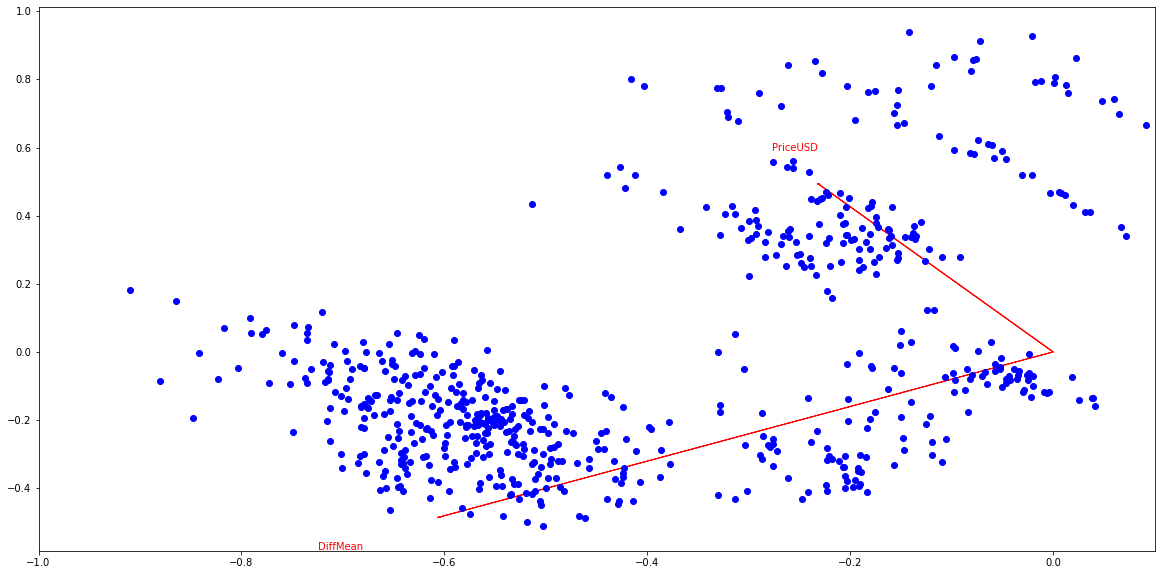

array(['DiffMean', 'PriceUSD'], dtype=object)

In [15]:
from sklearn.decomposition import PCA

n = len(df.columns)

pca = PCA(n_components = n)
pca.fit(df)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df)[:,0]
ys = pca.transform(df)[:,1]

#print(df.columns.values) #vector priceUSD
#print(xvector[14])
plt.xlim(-1,0.1)
lim = np.sqrt(xvector[3]**2 + yvector[3]**2)
feat = []

for i in range(len(xvector)):
    if(np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim and np.sign(xvector[i]) == np.sign(xvector[3])):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                 list(df.columns.values)[i], color='r')
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')

plt.show()
df.columns.values[feat]

## Eliminamos las variables que tienen una norma menor al vector PriceUSD y con distinta dirección

## Total de **variables restantes 2**

In [59]:
df_red = df[df.columns.values[feat]].copy()
#df_red = df_red.drop(['AdrActCnt','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxTfrCnt'],axis =1)

In [20]:
#Con 29 variables

import dcor
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt = df_wo.apply(lambda col1: df_wo.apply(lambda col2: distcorr(col1, col2)))

pd.options.display.float_format = '{:,.2f}'.format
rslt

,AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d
AdrActCnt,1.00,0.50,0.32,0.48,0.30,0.52,0.52,0.94,0.43,0.52,0.24
CapMrktCurUSD,0.50,1.00,0.45,0.91,0.63,0.71,0.71,0.50,0.81,0.84,0.29
DiffMean,0.32,0.45,1.00,0.43,0.75,0.89,0.89,0.24,0.52,0.47,0.52
PriceUSD,0.48,0.91,0.43,1.00,0.50,0.63,0.63,0.49,0.66,0.72,0.30
FeeTotNtv,0.30,0.63,0.75,0.50,1.00,0.88,0.88,0.27,0.69,0.64,0.48
SplyCur,0.52,0.71,0.89,0.63,0.88,1.00,1.00,0.46,0.73,0.72,0.52
SplyFF,0.52,0.71,0.89,0.63,0.88,1.00,1.00,0.47,0.72,0.72,0.52
TxTfrCnt,0.94,0.50,0.24,0.49,0.27,0.46,0.47,1.00,0.43,0.48,0.35
TxTfrValMeanUSD,0.43,0.81,0.52,0.66,0.69,0.73,0.72,0.43,1.00,0.84,0.35
TxTfrValUSD,0.52,0.84,0.47,0.72,0.64,0.72,0.72,0.48,0.84,1.00,0.27


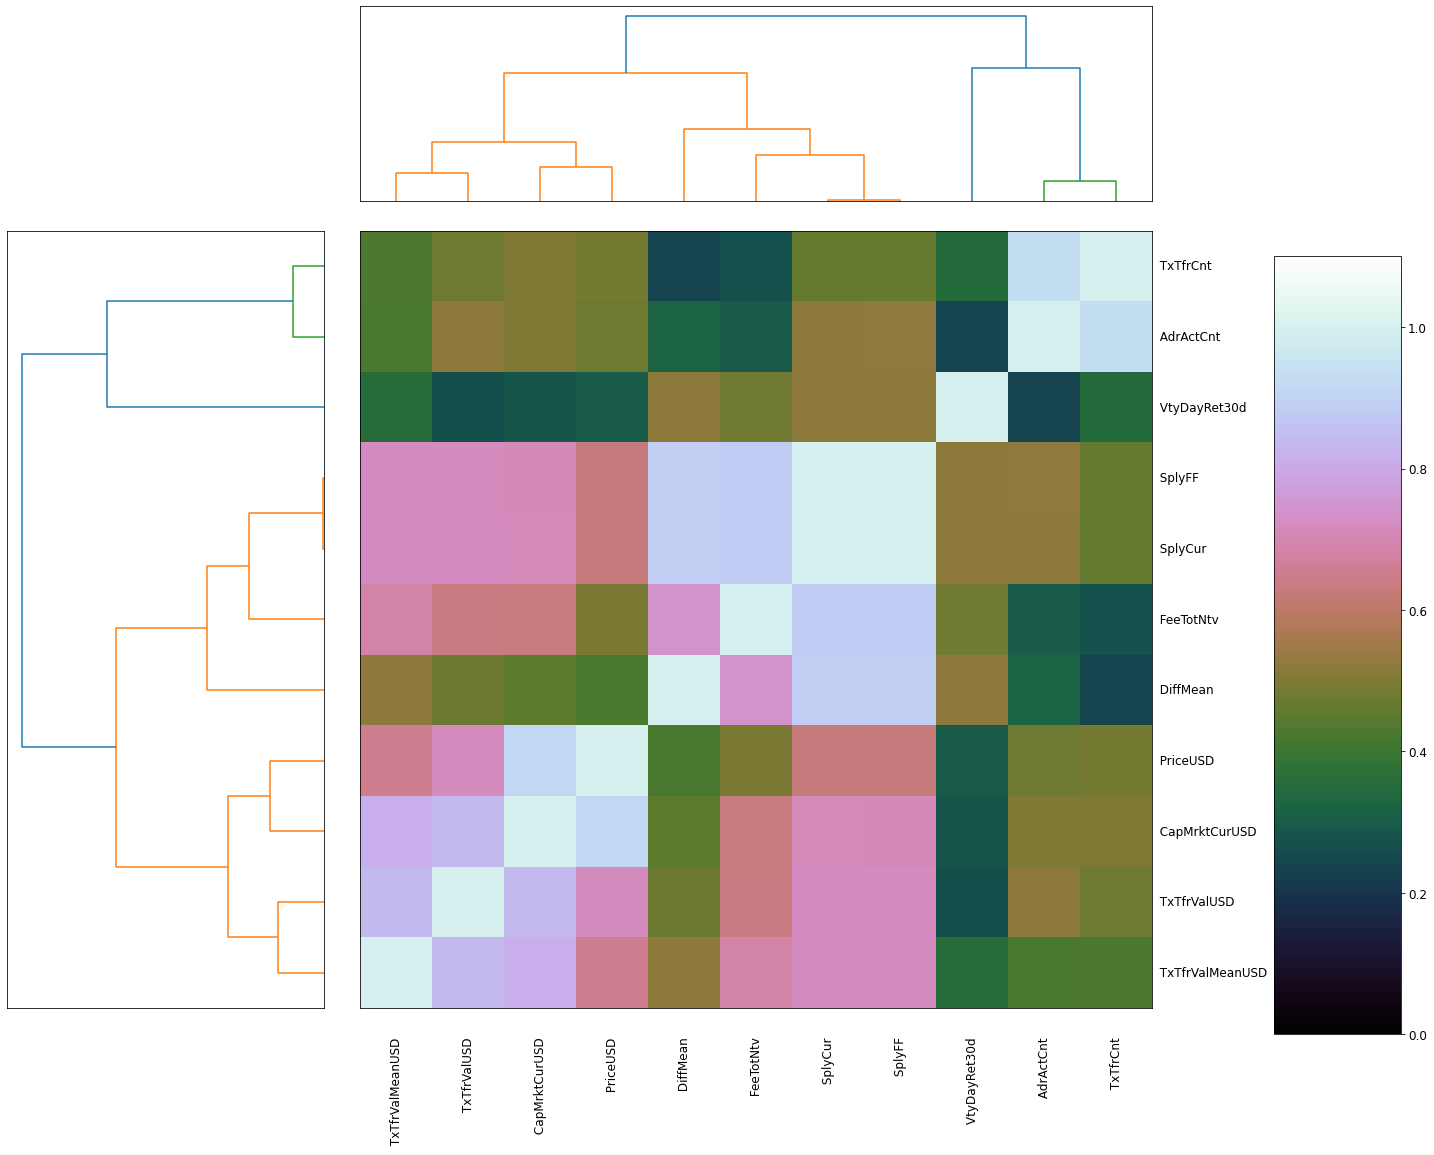

In [18]:
from biokit.viz import heatmap
import dcor

df_wo.rename(index=str, columns={"Gross pay transform": "Gross pay tr"}, inplace=True)
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_wo.apply(lambda col1: df_wo.apply(lambda col2: distcorr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('dcr_dendograma.png', dpi = 100)